In [4]:
# Cell 1: Import all required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

np.random.seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Cell 2: Load and explore the dataset
df = pd.read_csv('amazon.csv', encoding='utf-8-sig')

print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())
print("\nClass distribution:")
print(df['label'].value_counts())
print(f"Positive: {df['label'].value_counts()[1]} ({(df['label'].value_counts()[1]/len(df))*100:.2f}%)")
print(f"Negative: {df['label'].value_counts()[0]} ({(df['label'].value_counts()[0]/len(df))*100:.2f}%)")

Dataset shape: (19996, 2)

Column names: ['Text', 'label']

First 5 rows:
                                                Text  label
0  This is  the best apps acording to a bunch of ...      1
1  This is a pretty good version of the game for ...      1
2  this is a really . there are a bunch of levels...      1
3  This is a silly game and can be frustrating, b...      1
4  This is a terrific game on any pad. Hrs of fun...      1

Missing values:
Text     0
label    0
dtype: int64

Class distribution:
label
1    15230
0     4766
Name: count, dtype: int64
Positive: 15230 (76.17%)
Negative: 4766 (23.83%)


/tmp/ipython-input-2310096504.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([positive_lengths, negative_lengths], labels=['Positive', 'Negative'])


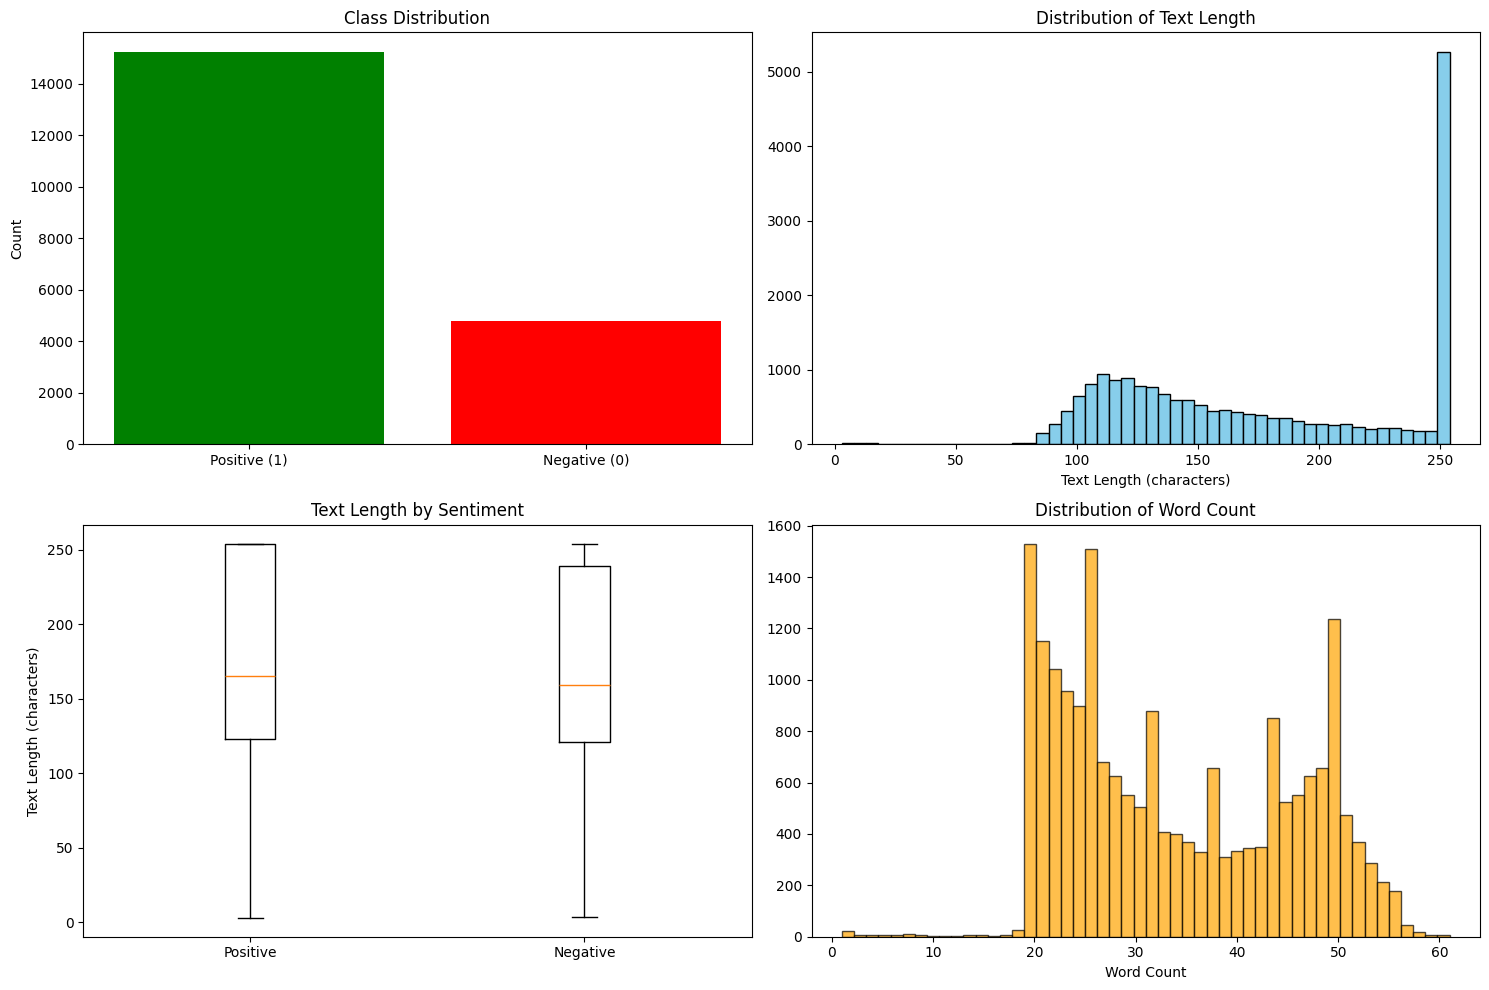

Average text length: 175.79 characters
Average word count: 33.94 words


In [6]:
# Cell 3: Data visualization - class distribution and text analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Class distribution
axes[0, 0].bar(['Positive (1)', 'Negative (0)'], df['label'].value_counts().values, color=['green', 'red'])
axes[0, 0].set_title('Class Distribution')
axes[0, 0].set_ylabel('Count')

# Text length distribution
df['text_length'] = df['Text'].apply(len)
axes[0, 1].hist(df['text_length'], bins=50, color='skyblue', edgecolor='black')
axes[0, 1].set_title('Distribution of Text Length')
axes[0, 1].set_xlabel('Text Length (characters)')

# Text length by sentiment
positive_lengths = df[df['label'] == 1]['text_length']
negative_lengths = df[df['label'] == 0]['text_length']
axes[1, 0].boxplot([positive_lengths, negative_lengths], labels=['Positive', 'Negative'])
axes[1, 0].set_title('Text Length by Sentiment')
axes[1, 0].set_ylabel('Text Length (characters)')

# Word count distribution
df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))
axes[1, 1].hist(df['word_count'], bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution of Word Count')
axes[1, 1].set_xlabel('Word Count')

plt.tight_layout()
plt.show()

print(f"Average text length: {df['text_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")

In [7]:
# Cell 4: Text preprocessing function
import nltk
nltk.download('punkt_tab') # Added to resolve LookupError

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 1]

    return ' '.join(tokens)

# Apply preprocessing
df['cleaned_text'] = df['Text'].apply(preprocess_text)
print("Text preprocessing completed.")
print(f"Original: {df.loc[0, 'Text'][:100]}...")
print(f"Cleaned: {df.loc[0, 'cleaned_text'][:100]}...")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Text preprocessing completed.
Original: This is  the best apps acording to a bunch of people and I agree it has bombs eggs pigs TNT king pig...
Cleaned: best apps acording bunch people agree bomb egg pig tnt king pig realustic stuff...


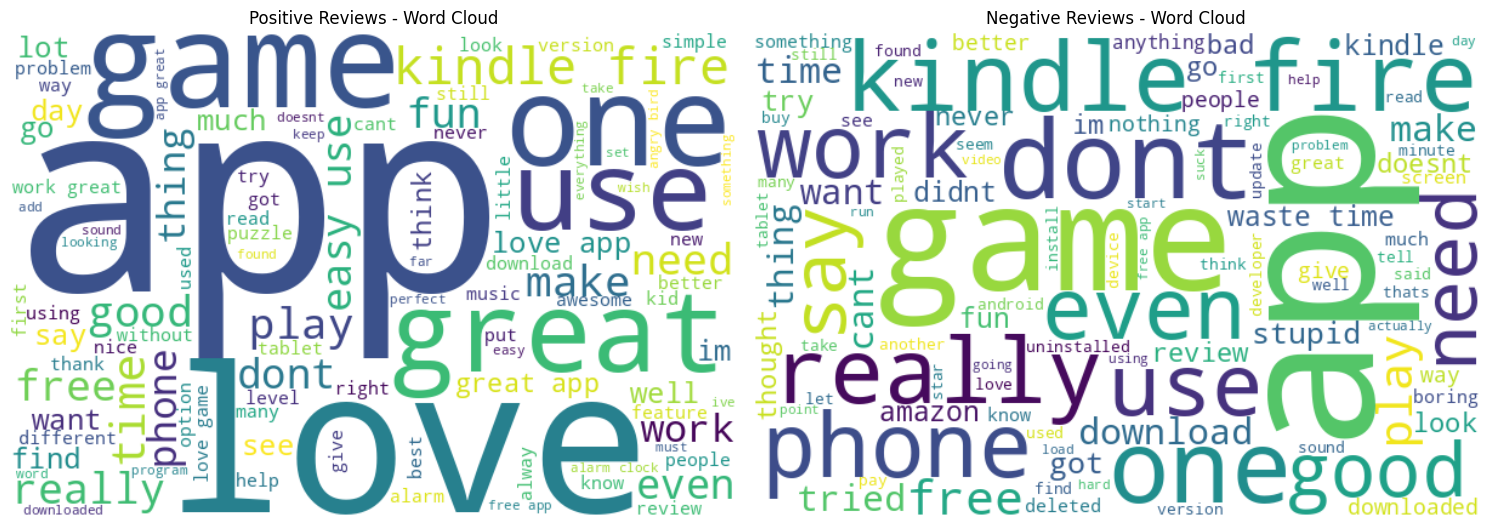

In [8]:
# Cell 5: Word cloud visualization
positive_text = ' '.join(df[df['label'] == 1]['cleaned_text'])
negative_text = ' '.join(df[df['label'] == 0]['cleaned_text'])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

wordcloud_pos = WordCloud(width=600, height=400, background_color='white', max_words=100).generate(positive_text)
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].set_title('Positive Reviews - Word Cloud')
axes[0].axis('off')

wordcloud_neg = WordCloud(width=600, height=400, background_color='white', max_words=100).generate(negative_text)
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].set_title('Negative Reviews - Word Cloud')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Cell 6: Feature engineering with TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.7
)

X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])
y = df['label']

print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Number of features: {X_tfidf.shape[1]}")

TF-IDF matrix shape: (19996, 5000)
Number of features: 5000


In [10]:
# Cell 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training class distribution:\n{y_train.value_counts()}")
print(f"Test class distribution:\n{y_test.value_counts()}")

Training set size: 15996 samples
Test set size: 4000 samples
Training class distribution:
label
1    12183
0     3813
Name: count, dtype: int64
Test class distribution:
label
1    3047
0     953
Name: count, dtype: int64


In [11]:
# Cell 8: Model 1 - Logistic Regression
print("="*50)
print("MODEL 1: LOGISTIC REGRESSION WITH TF-IDF")
print("="*50)

logreg_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'
)

logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)
y_pred_proba_logreg = logreg_model.predict_proba(X_test)[:, 1]

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)

print(f"Accuracy:  {accuracy_logreg:.4f}")
print(f"Precision: {precision_logreg:.4f}")
print(f"Recall:    {recall_logreg:.4f}")
print(f"F1-Score:  {f1_logreg:.4f}")
print(f"ROC-AUC:   {roc_auc_logreg:.4f}")

cv_scores_logreg = cross_val_score(logreg_model, X_tfidf, y, cv=5, scoring='accuracy')
print(f"\nCV Scores (5-fold): {cv_scores_logreg}")
print(f"Mean CV Accuracy: {cv_scores_logreg.mean():.4f}")

feature_names = tfidf_vectorizer.get_feature_names_out()
coefs = logreg_model.coef_[0]
top_features_idx = np.argsort(np.abs(coefs))[-10:][::-1]
print("\nTop 10 features (Logistic Regression):")
for idx in top_features_idx:
    print(f"{feature_names[idx]:20} Coefficient: {coefs[idx]:.4f}")

MODEL 1: LOGISTIC REGRESSION WITH TF-IDF
Accuracy:  0.8868
Precision: 0.9541
Recall:    0.8943
F1-Score:  0.9233
ROC-AUC:   0.9493

CV Scores (5-fold): [0.8745     0.87996999 0.83170793 0.8792198  0.86946737]
Mean CV Accuracy: 0.8670

Top 10 features (Logistic Regression):
love                 Coefficient: 9.5957
great                Coefficient: 8.0690
awesome              Coefficient: 5.3529
easy                 Coefficient: 5.1322
deleted              Coefficient: -4.9996
boring               Coefficient: -4.7300
waste                Coefficient: -4.7169
best                 Coefficient: 4.7026
uninstalled          Coefficient: -4.5301
fun                  Coefficient: 4.4350


In [12]:
# Cell 9: Model 2 - Random Forest
print("\n" + "="*50)
print("MODEL 2: RANDOM FOREST WITH TF-IDF")
print("="*50)

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Accuracy:  {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"F1-Score:  {f1_rf:.4f}")
print(f"ROC-AUC:   {roc_auc_rf:.4f}")

cv_scores_rf = cross_val_score(rf_model, X_tfidf, y, cv=5, scoring='accuracy')
print(f"\nCV Scores (5-fold): {cv_scores_rf}")
print(f"Mean CV Accuracy: {cv_scores_rf.mean():.4f}")

feature_importances = rf_model.feature_importances_
top_features_idx_rf = np.argsort(feature_importances)[-10:][::-1]
print("\nTop 10 features (Random Forest):")
for idx in top_features_idx_rf:
    print(f"{feature_names[idx]:20} Importance: {feature_importances[idx]:.4f}")


MODEL 2: RANDOM FOREST WITH TF-IDF
Accuracy:  0.8810
Precision: 0.8998
Recall:    0.9495
F1-Score:  0.9240
ROC-AUC:   0.9293

CV Scores (5-fold): [0.872      0.88347087 0.84596149 0.86846712 0.88622156]
Mean CV Accuracy: 0.8712

Top 10 features (Random Forest):
love                 Importance: 0.0415
great                Importance: 0.0357
easy                 Importance: 0.0168
fun                  Importance: 0.0113
waste                Importance: 0.0097
best                 Importance: 0.0095
awesome              Importance: 0.0082
dont                 Importance: 0.0080
deleted              Importance: 0.0077
use                  Importance: 0.0077


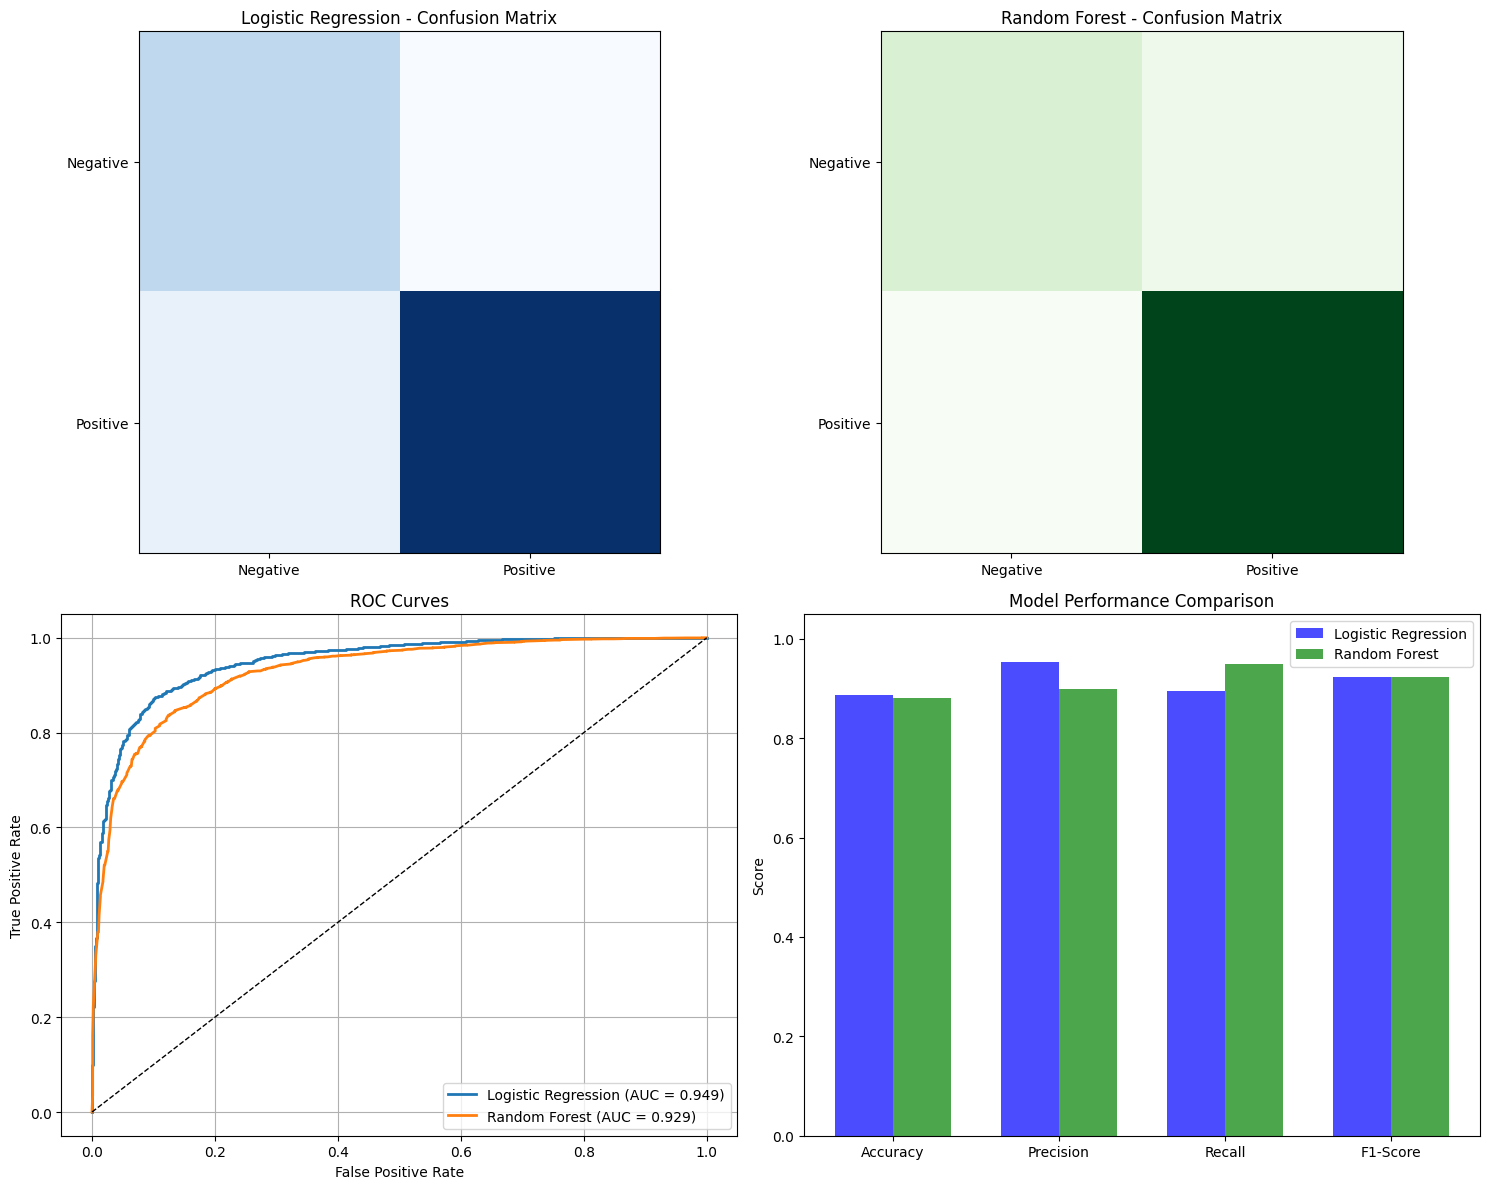

MODEL PERFORMANCE COMPARISON:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression   0.88675   0.954132 0.894322  0.923259 0.949286
      Random Forest   0.88100   0.899844 0.949458  0.923986 0.929261


In [13]:
# Cell 10: Model comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrices
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
cm_rf = confusion_matrix(y_test, y_pred_rf)

axes[0, 0].imshow(cm_logreg, interpolation='nearest', cmap=plt.cm.Blues)
axes[0, 0].set_title('Logistic Regression - Confusion Matrix')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_yticks([0, 1])
axes[0, 0].set_xticklabels(['Negative', 'Positive'])
axes[0, 0].set_yticklabels(['Negative', 'Positive'])

axes[0, 1].imshow(cm_rf, interpolation='nearest', cmap=plt.cm.Greens)
axes[0, 1].set_title('Random Forest - Confusion Matrix')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_yticks([0, 1])
axes[0, 1].set_xticklabels(['Negative', 'Positive'])
axes[0, 1].set_yticklabels(['Negative', 'Positive'])

# ROC Curves
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_proba_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

axes[1, 0].plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.3f})', linewidth=2)
axes[1, 0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})', linewidth=2)
axes[1, 0].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves')
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(True)

# Metric Comparison Bar Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

rects1 = axes[1, 1].bar(x - width/2,
                       [accuracy_logreg, precision_logreg, recall_logreg, f1_logreg],
                       width, label='Logistic Regression', color='blue', alpha=0.7)
rects2 = axes[1, 1].bar(x + width/2,
                       [accuracy_rf, precision_rf, recall_rf, f1_rf],
                       width, label='Random Forest', color='green', alpha=0.7)

axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Model Performance Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()
axes[1, 1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

# Print comparison table
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_logreg, accuracy_rf],
    'Precision': [precision_logreg, precision_rf],
    'Recall': [recall_logreg, recall_rf],
    'F1-Score': [f1_logreg, f1_rf],
    'ROC-AUC': [roc_auc_logreg, roc_auc_rf]
})

print("MODEL PERFORMANCE COMPARISON:")
print(comparison_df.to_string(index=False))

In [14]:
# Cell 11: Hyperparameter tuning (Grid Search)
print("\n" + "="*50)
print("HYPERPARAMETER TUNING")
print("="*50)

# Logistic Regression Grid Search
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

grid_search_logreg = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'),
    param_grid_logreg,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

grid_search_logreg.fit(X_train, y_train)
print(f"Best Logistic Regression parameters: {grid_search_logreg.best_params_}")
print(f"Best Logistic Regression score: {grid_search_logreg.best_score_:.4f}")

# Random Forest Grid Search
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

grid_search_rf.fit(X_train, y_train)
print(f"\nBest Random Forest parameters: {grid_search_rf.best_params_}")
print(f"Best Random Forest score: {grid_search_rf.best_score_:.4f}")


HYPERPARAMETER TUNING
Best Logistic Regression parameters: {'C': 10, 'penalty': 'l2'}
Best Logistic Regression score: 0.8913

Best Random Forest parameters: {'max_depth': None, 'n_estimators': 100}
Best Random Forest score: 0.8713


In [15]:
# Cell 12: Error analysis
print("\n" + "="*50)
print("ERROR ANALYSIS")
print("="*50)

results_df = pd.DataFrame({
    'Original_Text': df.loc[y_test.index, 'Text'],
    'Actual': y_test,
    'LR_Prediction': y_pred_logreg,
    'RF_Prediction': y_pred_rf
})

results_df['LR_Correct'] = results_df['Actual'] == results_df['LR_Prediction']
results_df['RF_Correct'] = results_df['Actual'] == results_df['RF_Prediction']

print(f"Logistic Regression misclassified: {(~results_df['LR_Correct']).sum()} samples")
print(f"Random Forest misclassified: {(~results_df['RF_Correct']).sum()} samples")

both_wrong = results_df[(~results_df['LR_Correct']) & (~results_df['RF_Correct'])]
print(f"\nSamples where BOTH models were wrong: {len(both_wrong)}")

if len(both_wrong) > 0:
    print("\nExample where both models failed:")
    print("-" * 80)
    row = both_wrong.iloc[0]
    print(f"Text: {row['Original_Text'][:200]}...")
    print(f"Actual: {'Positive' if row['Actual'] == 1 else 'Negative'}")
    print(f"LR Prediction: {'Positive' if row['LR_Prediction'] == 1 else 'Negative'}")
    print(f"RF Prediction: {'Positive' if row['RF_Prediction'] == 1 else 'Negative'}")


ERROR ANALYSIS
Logistic Regression misclassified: 453 samples
Random Forest misclassified: 476 samples

Samples where BOTH models were wrong: 249

Example where both models failed:
--------------------------------------------------------------------------------
Text: first off i am happy my favorites on my iphone transfered over. but i cant figure out how to add something to my favorites on the kindle version. what REALLY ticks me off is that there is no tab pro o...
Actual: Negative
LR Prediction: Positive
RF Prediction: Positive


In [16]:
# Cell 13: Prediction pipeline
print("\n" + "="*50)
print("PREDICTION PIPELINE")
print("="*50)

def predict_sentiment(text, model, vectorizer):
    cleaned_text = preprocess_text(text)
    text_vectorized = vectorizer.transform([cleaned_text])
    prediction = model.predict(text_vectorized)[0]
    probability = model.predict_proba(text_vectorized)[0][1]

    return {
        'sentiment': 'Positive' if prediction == 1 else 'Negative',
        'probability': probability
    }

test_samples = [
    "This is the best product I've ever bought! Absolutely love it!",
    "Worst purchase of my life. Completely useless and broke in 2 days.",
    "It's okay, nothing special but gets the job done."
]

print("Testing prediction pipeline:")
print("-" * 80)
for i, sample in enumerate(test_samples):
    result_lr = predict_sentiment(sample, logreg_model, tfidf_vectorizer)
    result_rf = predict_sentiment(sample, rf_model, tfidf_vectorizer)

    print(f"\nSample {i+1}: {sample[:50]}...")
    print(f"Logistic Regression: {result_lr['sentiment']} ({result_lr['probability']:.3f})")
    print(f"Random Forest: {result_rf['sentiment']} ({result_rf['probability']:.3f})")


PREDICTION PIPELINE
Testing prediction pipeline:
--------------------------------------------------------------------------------

Sample 1: This is the best product I've ever bought! Absolut...
Logistic Regression: Positive (0.938)
Random Forest: Positive (0.980)

Sample 2: Worst purchase of my life. Completely useless and ...
Logistic Regression: Negative (0.069)
Random Forest: Negative (0.262)

Sample 3: It's okay, nothing special but gets the job done....
Logistic Regression: Negative (0.400)
Random Forest: Negative (0.332)



Saving the trained random forest pickle file

In [17]:
import joblib

# Using the exact variable names from your Cell 6 and training cells
if 'tfidf_vectorizer' in locals() and 'rf_model' in locals():
    joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
    joblib.dump(rf_model, 'random_forest_model.pkl')
    print("✅ Files saved: tfidf_vectorizer.pkl and random_forest_model.pkl")
else:
    print("❌ Error: Variables not found. Please run your training cells first!")

✅ Files saved: tfidf_vectorizer.pkl and random_forest_model.pkl


Random Forest Interface

In [21]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import joblib
import re

# Load the saved assets
model = joblib.load('random_forest_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Define the UI components
header = widgets.HTML("<h2>🛍️ Random forest Amazon Sentiment Analysis Tool</h2>")
text_input = widgets.Textarea(placeholder='Enter your review here...', description='Review:', layout={'height': '100px', 'width': '70%'})
btn = widgets.Button(description='Analyze Sentiment', button_style='primary')
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        review = text_input.value
        if review:
            # Re-use your specific preprocessing logic
            cleaned = review.lower()
            cleaned = re.sub(r'[^a-zA-Z\s]', '', cleaned)

            # Vectorize and Predict
            vec_input = vectorizer.transform([cleaned])
            prediction = model.predict(vec_input)[0]

            result = "POSITIVE 😊" if prediction == 1 else "NEGATIVE 😞"
            color = "green" if prediction == 1 else "red"
            display(widgets.HTML(f"<h3 style='color:{color}'>Prediction: {result}</h3>"))
        else:
            print("Please enter a review.")

btn.on_click(on_button_clicked)

# Display the Software Interface
display(header, text_input, btn, output)

HTML(value='<h2>🛍️ Random forest Amazon Sentiment Analysis Tool</h2>')

Textarea(value='', description='Review:', layout=Layout(height='100px', width='70%'), placeholder='Enter your …

Button(button_style='primary', description='Analyze Sentiment', style=ButtonStyle())

Output()

Saving the logistic regresstion in pickle file

In [19]:
import joblib

# Use the variable name for your Logistic Regression model from your notebook
if 'logreg_model' in locals():
    joblib.dump(logreg_model, 'logistic_regression_model.pkl')
    print("✅ Logistic Regression model saved!")
else:
    print("❌ Error: 'logreg_model' not found. Please run your training cell first.")

✅ Logistic Regression model saved!


Runing the logistic regresstion model

In [22]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import joblib
import re

# Load the assets (Using Logistic Regression this time)
model = joblib.load('logistic_regression_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Define the UI components
header = widgets.HTML("<h2>📈 Logistic Regression: Sentiment Analysis Tool</h2>")
text_input = widgets.Textarea(
    placeholder='Enter your review here...',
    description='Review:',
    layout={'height': '100px', 'width': '70%'}
)
btn = widgets.Button(description='Analyze Sentiment', button_style='success')
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        review = text_input.value
        if review:
            # Preprocessing
            cleaned = review.lower()
            cleaned = re.sub(r'[^a-zA-Z\s]', '', cleaned)

            # Vectorize and Predict
            vec_input = vectorizer.transform([cleaned])
            prediction = model.predict(vec_input)[0]

            result = "POSITIVE 😊" if prediction == 1 else "NEGATIVE 😞"
            color = "#28a745" if prediction == 1 else "#dc3545" # Green or Red
            display(widgets.HTML(f"<h3 style='color:{color}'>Logistic Regression Prediction: {result}</h3>"))
        else:
            print("Please enter a review.")

btn.on_click(on_button_clicked)

# Display the Software Interface
display(header, text_input, btn, output)

HTML(value='<h2>📈 Logistic Regression: Sentiment Analysis Tool</h2>')

Textarea(value='', description='Review:', layout=Layout(height='100px', width='70%'), placeholder='Enter your …

Button(button_style='success', description='Analyze Sentiment', style=ButtonStyle())

Output()